# Project Overview

Tanzania, as a developing country, struggles with providing clean water to its population of over 57,000,000. There are many waterpoints already established in the country, but some are in need of repair while others have failed altogether.

Can you predict which water pumps are faulty?

Using data from Taarifa and the Tanzanian Ministry of Water, can you predict which pumps are functional, which need some repairs, and which don't work at all? This is an intermediate-level practice competition. Predict one of these three classes based on a number of variables about what kind of pump is operating, when it was installed, and how it is managed. A smart understanding of which waterpoints will fail can improve maintenance operations and ensure that clean, potable water is available to communities across Tanzania.

Build a classifier to predict the condition of a water well, using information about the sort of pump, when it was installed, etc. Note that this is a ternary classification problem.

<a href="https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/page/23/">Tanzanian Water Well Data</a>
 
This dataset is part of an active competition until April 31, 2021!



## Import packages

In [84]:
import pandas as pd
import numpy as np
import zipfile
import folium
import geopandas as gpd
import contextily as ctx
from shapely.geometry import Point
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import Lasso, Ridge, LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE

## Data

#### Import Data

In [2]:
X = pd.read_csv("../../references/training_set_values.csv", index_col = 'id')

In [3]:
y = pd.read_csv("../../references/training_set_labels.csv", index_col = 'id')['status_group']

#### Feature info

<a href="https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/page/25/">Link to information about features</a>

In [4]:
# amount_tsh - Total static head (amount water available to waterpoint)
# date_recorded - The date the row was entered - do not include
# funder - Who funded the well
# gps_height - Altitude of the well
# installer - Organization that installed the well
# longitude - GPS coordinate - do not include
# latitude - GPS coordinate - do not include
# wpt_name - Name of the waterpoint if there is one
# num_private -
# basin - Geographic water basin
# subvillage - Geographic location
# region - Geographic location
# region_code - Geographic location (coded)
# district_code - Geographic location (coded)
# lga - Geographic location
# ward - Geographic location
# population - Population around the well
# public_meeting - True/False - ?
# recorded_by - Group entering this row of data
# scheme_management - Who operates the waterpoint
# scheme_name - Who operates the waterpoint
# permit - If the waterpoint is permitted
# construction_year - Year the waterpoint was constructed
# extraction_type - The kind of extraction the waterpoint uses
# extraction_type_group - The kind of extraction the waterpoint uses
# extraction_type_class - The kind of extraction the waterpoint uses
# management - How the waterpoint is managed
# management_group - How the waterpoint is managed
# payment - What the water costs
# payment_type - What the water costs
# water_quality - The quality of the water
# quality_group - The quality of the water
# quantity - The quantity of water
# quantity_group - The quantity of water
# source - The source of the water
# source_type - The source of the water
# source_class - The source of the water
# waterpoint_type - The kind of waterpoint
# waterpoint_type_group - The kind of waterpoint

### Maps

#### Scatter Plot of Wells

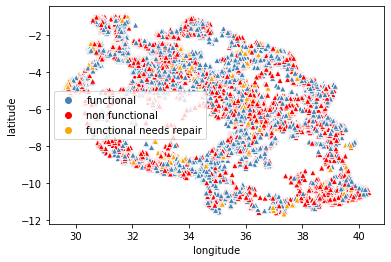

In [5]:
df_loc = X.join(y)[['longitude', 'latitude', 'status_group']]
df_loc = df_loc[df_loc['longitude']!=0]
df_loc.status_group.value_counts()

colors = {'functional': 'green', 'non functional': 'red', 'functional needs repair': 'orange' }
sns.scatterplot(data=df_loc, x = 'longitude', y = 'latitude', marker = '^', alpha = 1,
                hue = df_loc.status_group.tolist(), palette = ['steelblue', 'red', 'orange']);

#### Import shape files for Tanzania

In [6]:
# Uncomment to download shapefiles
# ! wget -P ../../data http://stacks.stanford.edu/file/druid:tn398yw9512/data.zip

In [7]:
# Uncomment to unzip shapefiles
# with zipfile.ZipFile('../../data/data.zip', 'r') as zip_ref:
#     zip_ref.extractall('../../data/shapefiles')

#### Create GeoDataFrames from Data
Convert crs from 4326 to 3857 (changes latitude and logitude format for plotting)

In [8]:
geo_df = gpd.read_file('../../data/shapefiles/TAN.shp')
geo_df = geo_df.to_crs(epsg = 3857)

C:\Users\Sin City\anaconda3\envs\learn-env\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [9]:
# Add a geometry column that holds Point objects with lat and long
df_loc['geometry'] = df_loc.apply(lambda x: Point(float(x.longitude), float(x.latitude)), axis=1)
gdf = gpd.GeoDataFrame(df_loc, geometry='geometry')
gdf.crs = "EPSG:4326"
gdf = gdf.to_crs(epsg = 3857)

C:\Users\Sin City\anaconda3\envs\learn-env\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


#### Create Folium map to show where Tanzania is

In [83]:
m = folium.Map(location=[-6.3690, 34.8888], zoom_start = 5)
m.choropleth(geo_data=geo_df, fill_color='blue', fill_opacity=0.2, line_opacity=.1)
display(m)

C:\Users\Sin City\anaconda3\envs\learn-env\lib\site-packages\folium\folium.py:415: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning
C:\Users\Sin City\anaconda3\envs\learn-env\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


#### Geopandas plots with Contextly

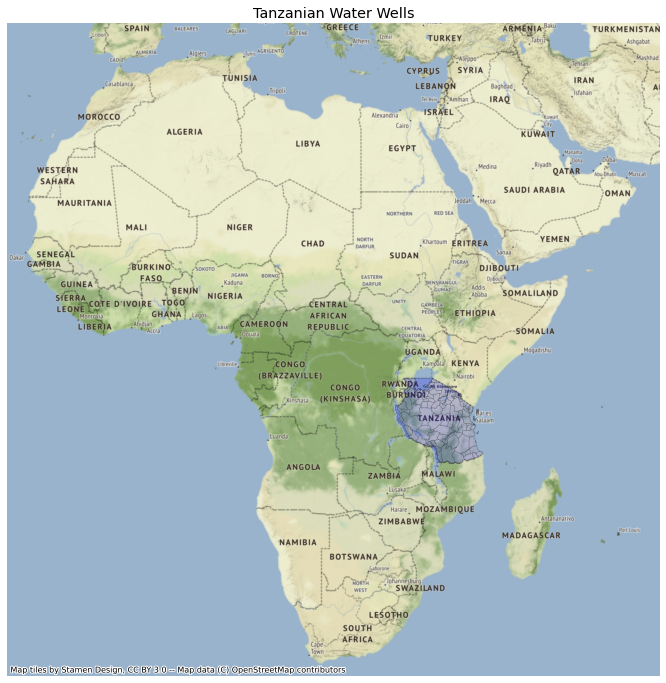

In [79]:
fig, ax = plt.subplots(figsize=(12,12))
geo_df.plot(ax=ax, color = 'blue', edgecolor = 'k', alpha = .2)

minx, miny, maxx, maxy = gdf.total_bounds
ax.set_xlim(minx-5500000, maxx+2500000)
ax.set_ylim(miny-3000000, maxy+5000000)

ctx.add_basemap(ax, zoom = 5) #source=ctx.providers.OpenStreetMap.Mapnik) lots of styles to choose from
plt.title('Tanzanian Water Wells')

ax.set_axis_off();

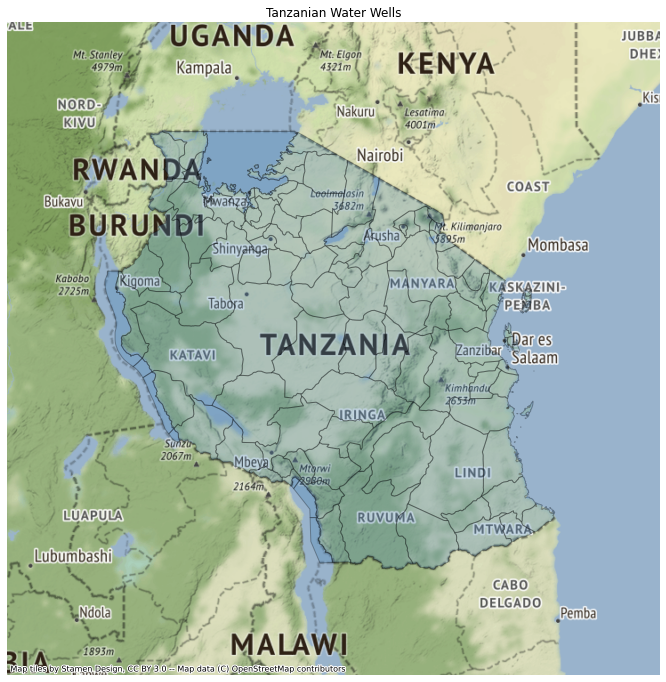

In [11]:
fig, ax = plt.subplots(figsize=(12,12))
geo_df.plot(ax=ax, color = 'steelblue', edgecolor = 'k', alpha = .3)

minx, miny, maxx, maxy = gdf.total_bounds
ax.set_xlim(minx-300000, maxx+300000)
ax.set_ylim(miny-300000, maxy+300000)

ctx.add_basemap(ax) #source=ctx.providers.OpenStreetMap.Mapnik) lots of styles to choose from
plt.title('Tanzanian Water Wells')

ax.set_axis_off();

#### Add Wells + Status to Plot

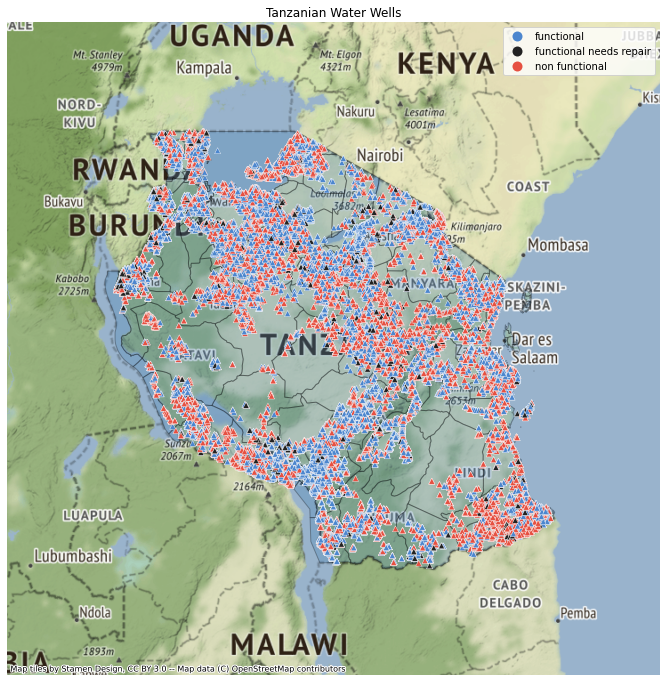

In [12]:
fig, ax = plt.subplots(figsize=(12,12))
geo_df.plot(ax=ax, color = 'steelblue', edgecolor = 'k', alpha = .3)

custom_palette = sns.diverging_palette(250, 15, l=55, center="dark", as_cmap=True)

gdf.plot(ax=ax, column = 'status_group', marker = '^', 
         edgecolor = 'white', cmap = custom_palette,
         linewidth=0.4, legend = True)

minx, miny, maxx, maxy = gdf.total_bounds
ax.set_xlim(minx-300000, maxx+300000)
ax.set_ylim(miny-300000, maxy+300000)

ctx.add_basemap(ax)#, source=ctx.providers.OpenStreetMap.Mapnik)
plt.title('Tanzanian Water Wells')
ax.set_axis_off();

### Data Cleaning

#### Drop Date and NA and unique identifier columns for now

In [13]:
# X.info()

In [14]:
columns_with_na = ['permit', 'scheme_name', 'scheme_management', 'public_meeting', 'subvillage', 'installer', 'funder']
X.drop(columns_with_na, axis=1, inplace=True)

In [15]:
columns_with_specific_location_and_names = ['ward', 'wpt_name']
X.drop(columns_with_specific_location_and_names, axis=1, inplace=True)

In [16]:
X.drop('date_recorded', axis=1, inplace=True)

### EDA Visuals

## Preprocess Data for Model

#### Train Test Split

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 42)

#### Split Data into continuous and categorical

In [19]:
X.dtypes.value_counts()

object     20
int64       6
float64     3
dtype: int64

In [20]:
X_train_cat = X_train.select_dtypes(include='object')
X_train_cont = X_train.select_dtypes(exclude='object')
X_test_cat = X_test.select_dtypes(include='object')
X_test_cont = X_test.select_dtypes(exclude='object')

#### Simple Imputer to fill null numeric values

In [21]:
si = SimpleImputer()
X_train_imp = pd.DataFrame(si.fit_transform(X_train_cont), index = X_train_cont.index, columns = X_train_cont.columns)
X_test_imp = pd.DataFrame(si.transform(X_test_cont), index = X_test_cont.index, columns = X_test_cont.columns)

#### Standard Scaler to scale numeric values

In [22]:
ss = StandardScaler()
X_train_sc = pd.DataFrame(ss.fit_transform(X_train_imp), index = X_train_imp.index, columns = X_train_imp.columns)
X_test_sc = pd.DataFrame(ss.transform(X_test_imp), index = X_test_imp.index, columns = X_test_imp.columns)

#### OneHotEncoder for categorical columns

In [23]:
# X_train_cat.info()

In [24]:
ohe = OneHotEncoder(drop = 'if_binary', sparse = False)
X_train_ohe = pd.DataFrame(ohe.fit_transform(X_train_cat),
                          columns = ohe.get_feature_names(X_train_cat.columns), index = X_train_cat.index)
X_test_ohe = pd.DataFrame(ohe.transform(X_test_cat),
                          columns = ohe.get_feature_names(X_test_cat.columns), index = X_test_cat.index)

#### Join numeric and object DataFrames back together after preprocessing

In [25]:
X_train_fin = X_train_sc.join(X_train_ohe)
X_test_fin = X_test_sc.join(X_test_ohe)
print('Features Count: ', X_train_fin.shape[1])

Features Count:  291


## Modeling

#### Create a Baseline Model

In [26]:
lr = LogisticRegression(max_iter=1000, random_state = 42)
lr.fit(X_train_fin, y_train)

LogisticRegression(max_iter=1000, random_state=42)

#### Score model on training data

In [27]:
# Score on our training data
y_pred = lr.predict(X_train_fin)
print(classification_report(y_train, y_pred)) 

                         precision    recall  f1-score   support

             functional       0.73      0.90      0.81     24161
functional needs repair       0.58      0.12      0.20      3243
         non functional       0.80      0.67      0.72     17146

               accuracy                           0.75     44550
              macro avg       0.70      0.56      0.58     44550
           weighted avg       0.75      0.75      0.73     44550



In [28]:
# Note - This cell takes time to run
# val = cross_val_score(lr, X_train_fin, y_train, cv=5)
# val

#### Score model on testing data

In [29]:
# Score on our testing data
y_pred = lr.predict(X_test_fin)
print(classification_report(y_test, y_pred)) 

                         precision    recall  f1-score   support

             functional       0.73      0.89      0.80      8098
functional needs repair       0.51      0.12      0.19      1074
         non functional       0.78      0.66      0.72      5678

               accuracy                           0.75     14850
              macro avg       0.68      0.56      0.57     14850
           weighted avg       0.74      0.75      0.73     14850



#### Coefficients of Features

In [30]:
coef = pd.DataFrame(lr.coef_, columns = X_test_fin.columns).transpose()

In [31]:
pd.set_option('display.max_rows', 500)
# coef

### Refining our Model

#### Using Smote to Deal with Class Imbalance

In [32]:
y_train.value_counts()

functional                 24161
non functional             17146
functional needs repair     3243
Name: status_group, dtype: int64

In [33]:
print("Before OverSampling, counts of label 'functional needs repair': {}".format(sum(y_train == 'functional needs repair'))) 
print("Before OverSampling, counts of label 'functional': {}".format(sum(y_train == 'functional'))) 
print("Before OverSampling, counts of label 'non functional': {} \n".format(sum(y_train == 'non functional'))) 
  
# import SMOTE module from imblearn library 
# pip install imblearn (if you don't have imblearn in your system) 
sm = SMOTE(random_state = 42) 
X_train_res, y_train_res = sm.fit_sample(X_train_fin, y_train.ravel()) 

print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape)) 
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape)) 

print("After OverSampling, counts of label 'functional needs repair': {}".format(sum(y_train_res == 'functional needs repair'))) 
print("After OverSampling, counts of label 'functional': {}".format(sum(y_train_res == 'functional'))) 
print("After OverSampling, counts of label 'non functional': {}".format(sum(y_train_res == 'non functional')))

Before OverSampling, counts of label 'functional needs repair': 3243
Before OverSampling, counts of label 'functional': 24161
Before OverSampling, counts of label 'non functional': 17146 

After OverSampling, the shape of train_X: (72483, 291)
After OverSampling, the shape of train_y: (72483,) 

After OverSampling, counts of label 'functional needs repair': 24161
After OverSampling, counts of label 'functional': 24161
After OverSampling, counts of label 'non functional': 24161


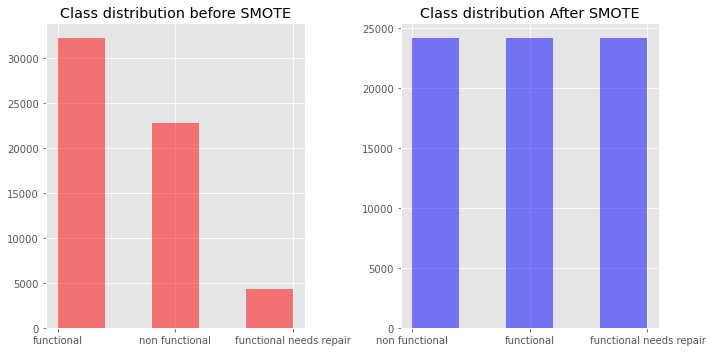

In [73]:
plt.style.use('ggplot')
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (10,5)) 
ax1.hist(y, color = 'red', alpha = .5, bins = 5)
ax1.set_title('Class distribution before SMOTE')
ax2.hist(y_train_res, color = 'blue', alpha = .5, bins = 5)
ax2.set_title('Class distribution After SMOTE')
fig.tight_layout();

#### Model After Smote

In [58]:
lr2 = LogisticRegression(max_iter=1000, random_state = 42)
lr2.fit(X_train_res, y_train_res)

LogisticRegression(max_iter=1000, random_state=42)

In [59]:
# Score on our training data
y_pred = lr2.predict(X_train_res)
print(classification_report(y_train_res, y_pred))

                         precision    recall  f1-score   support

             functional       0.65      0.64      0.65     24161
functional needs repair       0.65      0.74      0.69     24161
         non functional       0.76      0.66      0.70     24161

               accuracy                           0.68     72483
              macro avg       0.68      0.68      0.68     72483
           weighted avg       0.68      0.68      0.68     72483



In [80]:
# Score on our testing data
y_pred = lr2.predict(X_test_fin)
print(classification_report(y_test, y_pred))

                         precision    recall  f1-score   support

             functional       0.80      0.63      0.70      8098
functional needs repair       0.21      0.72      0.32      1074
         non functional       0.77      0.65      0.70      5678

               accuracy                           0.64     14850
              macro avg       0.59      0.66      0.58     14850
           weighted avg       0.75      0.64      0.68     14850



Our accuracy is now more even across classes, especially on the training data. However on the testing data, while the recall score soared, the precision score plummeted? The f1 score is still not great on the testing data either but really improved on the training data for class "functional needs repair". Considering our model is working much better on our training data than our testing data, we could use regularization techniques to avoid overfitting.

#### Feature Selection

In [97]:
from sklearn.ensemble import ExtraTreesClassifier

#use inbuilt class feature_importances of tree based classifiers
model = ExtraTreesClassifier()
model.fit(X_train_res,y_train_res)

(72483, 291)

In [188]:
# print(model.feature_importances_) 
feature_importance_df = pd.DataFrame(model.feature_importances_, index=X_train_res.columns).sort_values(by = 0, ascending = False)
feature_importance_df

,0
longitude,0.113874
latitude,0.110266
gps_height,0.052043
construction_year,0.041432
population,0.038266
quantity_group_dry,0.029721
quantity_dry,0.029579
district_code,0.014321
quantity_group_enough,0.014040
amount_tsh,0.011623


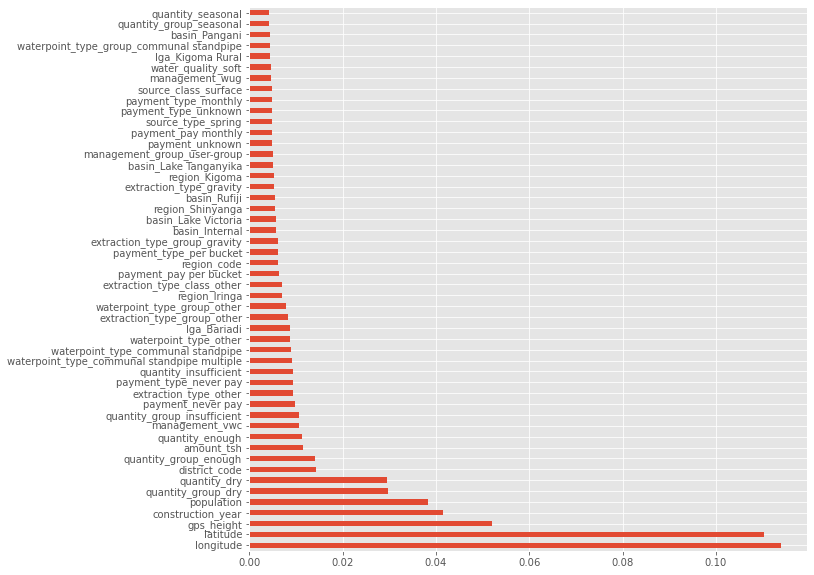

In [129]:
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X_train_res.columns)
fig = plt.subplots(figsize = (10,10))
feat_importances.nlargest(50).plot(kind='barh')
plt.show();

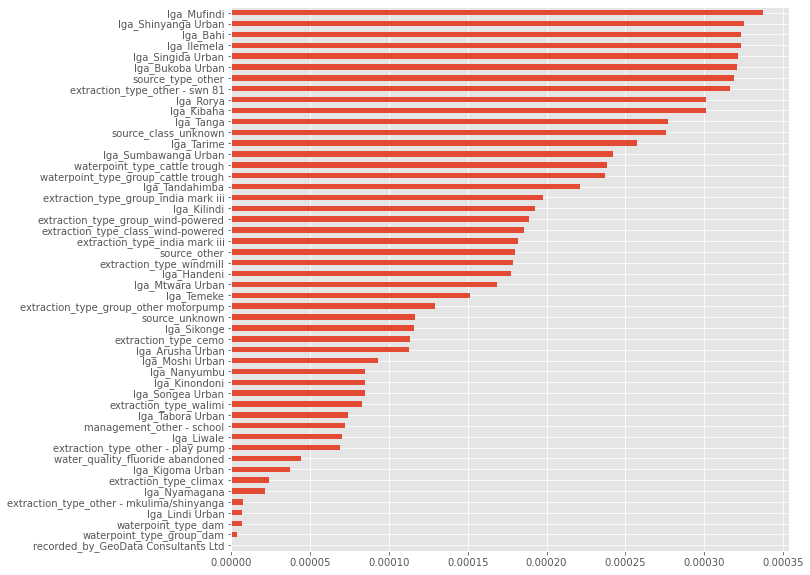

In [124]:
fig = plt.subplots(figsize = (10,10))
feat_importances.nsmallest(50).plot(kind='barh');


#### Model with filtered feature selection

In [174]:
print('Feature count: ', X_train_res.shape[1])

Feature count:  291


In [183]:
# Filter training and testing data with largest features
X_train_filt = X_train_res[feat_importances.nlargest(210).index]
X_test_filt = X_test_fin[feat_importances.nlargest(210).index]

In [184]:
print('Feature count: ', X_train_filt.shape[1])

Feature count:  210


In [185]:
lr3 = LogisticRegression(max_iter=1000, random_state = 42)
lr3.fit(X_train_filt, y_train_res)

LogisticRegression(max_iter=1000, random_state=42)

In [186]:
# Score on our training data
y_pred = lr3.predict(X_train_filt)
print(classification_report(y_train_res, y_pred))

                         precision    recall  f1-score   support

             functional       0.64      0.64      0.64     24161
functional needs repair       0.65      0.73      0.69     24161
         non functional       0.75      0.65      0.70     24161

               accuracy                           0.68     72483
              macro avg       0.68      0.68      0.68     72483
           weighted avg       0.68      0.68      0.68     72483



In [187]:
# Score on our testing data
y_pred = lr3.predict(X_test_filt)
print(classification_report(y_test, y_pred))

                         precision    recall  f1-score   support

             functional       0.80      0.63      0.70      8098
functional needs repair       0.20      0.71      0.32      1074
         non functional       0.76      0.64      0.70      5678

               accuracy                           0.64     14850
              macro avg       0.59      0.66      0.57     14850
           weighted avg       0.74      0.64      0.67     14850

